# Example Q3: Managing the Filter Pipeline
This example notebook shows how to use the `PipelineManager` to modify the signal processing on qubit data.

(c) Raytheon BBN Technologies 2018

We initialize a slightly more advanced channel library:

In [1]:
from QGL import *

cl = ChannelLibrary(db_resource_name=":memory:")

# Create five qubits and supporting hardware
for i in range(5):
    q1 = cl.new_qubit(f"q{i}")
    cl.new_APS2(f"BBNAPS2-{2*i+1}", address=f"192.168.5.{101+2*i}") 
    cl.new_APS2(f"BBNAPS2-{2*i+2}", address=f"192.168.5.{102+2*i}")
    cl.new_X6(f"X6_{i}", address=0)
    cl.new_source(f"Holz{2*i+1}", "HolzworthHS9000", f"HS9004A-009-{2*i}", power=-30)
    cl.new_source(f"Holz{2*i+2}", "HolzworthHS9000", f"HS9004A-009-{2*i+1}", power=-30) 
    cl.set_control(cl[f"q{i}"], cl[f"BBNAPS2-{2*i+1}"], generator=cl[f"Holz{2*i+1}"])
    cl.set_measure(cl[f"q{i}"], cl[f"BBNAPS2-{2*i+2}"], cl[f"X6_{i}"]["raw-1-1"], generator=cl[f"Holz{2*i+2}"])

cl.set_master(cl["BBNAPS2-1"], cl["BBNAPS2-1"].ch("m2"))
cl.commit()

## Creating the Default Filter Pipeline

In [2]:
from auspex.qubit import *

auspex-WARNING: 2019-02-27 14:00:18,359 ----> Could not load channelizer library; falling back to python methods.


The `PipelineManager` is analogous to the `ChannelLibrary` insomuchas it provides the user with an interface to programmatically modify the filter pipeline, and to save and load different versions of the pipeline.

In [3]:
pl = PipelineManager()

Pipelines are fairly predictable, and will provide some subset of the functionality of demodulating, integrating, average, and writing to file. Some of these can be done on hardware, some in software. The PipelineManager can guess what the user wants for a particular qubit by inspecting which equipment has been assigned to it using the `set_measure` command for the ChannelLibrary. For example, this ChannelLibrary has defined X6-1000M cards for readout, and the description of this instrument indicates that the highest level available stream is integrated. Thus, the PipelineManager automatically inserts the remaining averager and writer.

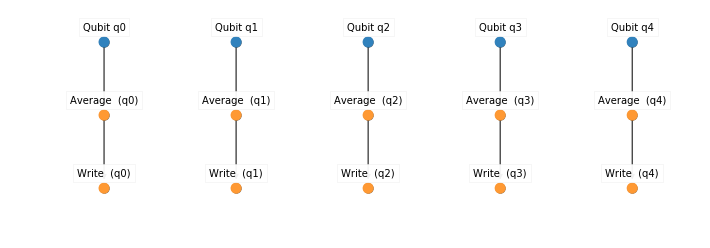

In [4]:
pl.create_default_pipeline()
pl.show_pipeline()

We can print the properties of individual filters or subgraphs:

In [5]:
pl.print("q1")

Dictionary access is provided to allow drilling down into the pipelines. One can use the specific label of a filter or simple its type in this access mode:

In [6]:
pl["q1"]["Average"]["Write"].filename = "new.h5"
pl.print("q1")

Here uncommitted changes are shown. This can be rectified in the standard way:

In [7]:
cl.commit()
pl.print("q1")

## Programmatic Modification of the Pipeline
Some simple convenience functions allow the use to easily specify complex pipeline structures.

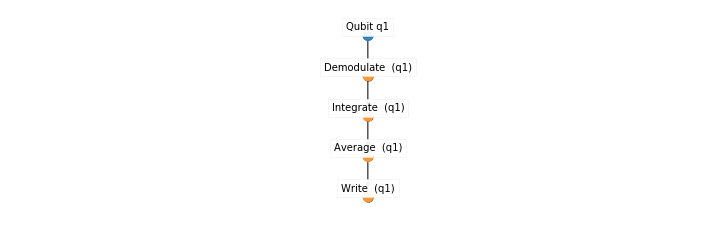

In [8]:
pl.save_as("simple")
pl["q1"].clear_pipeline()
pl["q1"].set_stream_type("raw")
pl["q1"].create_default_pipeline()
pl["q1"].show_pipeline()

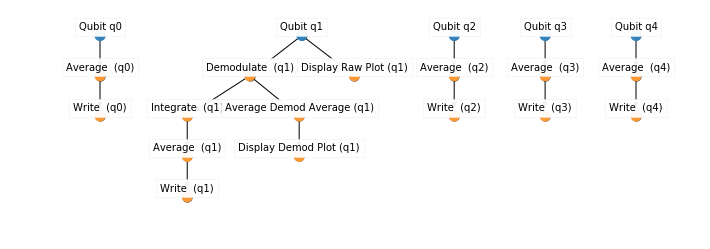

In [9]:
pl["q1"].add(Display(label="Raw Plot"))
pl["q1"]["Demodulate"].add(Average(label="Demod Average")).add(Display(label="Demod Plot"))
pl.show_pipeline()

As with the `ChannelLibrary` we can list save, list, and load versions of the filter pipeline.

In [10]:
pl.session.commit()
pl.save_as("custom")
pl.ls()

id,Year,Date,Time,Name
0,2019,Feb. 27,02:00:18 PM,working
1,2019,Feb. 27,02:00:21 PM,simple
2,2019,Feb. 27,02:00:21 PM,custom


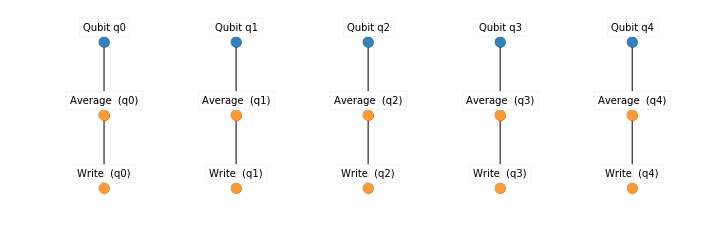

In [11]:
pl.load("simple")
pl.show_pipeline()

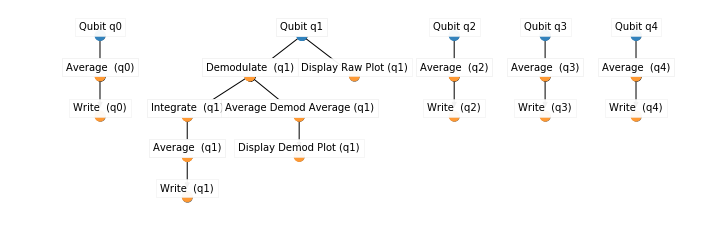

In [12]:
pl.load("custom")
pl.show_pipeline()